In [8]:
import sys
import time
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow.compat.v1.lite as lite

OBJECT_DETECTION_API_RESEARCH_PATH="/tf/share/notebooks/models/research"
BASE_MODEL_DIR="/tf/share/model/object_detection/base"
FROZEN_MODEL_OUT_DIR="/tf/share/model/object_detection/frozen"
TFLITE_MODEL_OUT_DIR="/tf/share/model/object_detection/tflite"
FONT_PATH='/tf/share/font/IPAfont00303/ipagp.ttf'
OID_V4_LABEL_MAP_PATH=OBJECT_DETECTION_API_RESEARCH_PATH+"/object_detection/data/oid_v4_label_map.pbtxt"
COCO_LABEL_MAP_PATH=OBJECT_DETECTION_API_RESEARCH_PATH+"/object_detection/data/mscoco_label_map.pbtxt"

test_img_path_li=[
    OBJECT_DETECTION_API_RESEARCH_PATH+"/object_detection/test_images/image1.jpg",
    OBJECT_DETECTION_API_RESEARCH_PATH+"/object_detection/test_images/image2.jpg",
]

sys.path.append(OBJECT_DETECTION_API_RESEARCH_PATH)
sys.path.append(OBJECT_DETECTION_API_RESEARCH_PATH+"/slim")
import object_detection.utils.label_map_util as label_map_util

def get_labellist_from_labelmap_pb(pb_path):
    labelmap=label_map_util.create_category_index_from_labelmap(pb_path)
    return [dic["name"] for i,dic in labelmap.items()]
    

def create_frozen_pb(model_name,model_dir=BASE_MODEL_DIR,out_root=FROZEN_MODEL_OUT_DIR):
    CONFIG_FILE=model_dir+"/"+model_name+"/pipeline.config"
    CHECKPOINT_PATH=model_dir+"/"+model_name+"/model.ckpt"
    OUTPUT_DIR=out_root+"/"+model_name
    OUTPUT_PATH=OUTPUT_DIR+"/tflite_graph.pb"
    PYTHONPATH="{}:{}/slim:PYTHONPATH".format(OBJECT_DETECTION_API_RESEARCH_PATH,OBJECT_DETECTION_API_RESEARCH_PATH)

    if not os.path.exists(OUTPUT_PATH):
        !export CUDA_VISIBLE_DEVICES="" && \
         export PYTHONPATH="$PYTHONPATH" && \
         python3 models/research/object_detection/export_tflite_ssd_graph.py \
         --pipeline_config_path=$CONFIG_FILE \
         --trained_checkpoint_prefix=$CHECKPOINT_PATH \
         --output_directory=$OUTPUT_DIR \
         --add_postprocessing_op=true
    
    print("---------------create_frozen_pb:complete")
    !ls $OUTPUT_DIR
    print("----------------------------------------")

def create_tflite_pb(model_name,shape,frozen_model_dir=FROZEN_MODEL_OUT_DIR,out_root=TFLITE_MODEL_OUT_DIR):
    INPUT_PATH=frozen_model_dir+"/"+model_name+"/tflite_graph.pb"
    OUTPUT_PATH=out_root+"/"+model_name+".tflite"

    if not os.path.exists(OUTPUT_PATH):
        converter = lite.TFLiteConverter.from_frozen_graph(
            INPUT_PATH,
            ["normalized_input_image_tensor"],
            ["TFLite_Detection_PostProcess","TFLite_Detection_PostProcess:1","TFLite_Detection_PostProcess:2","TFLite_Detection_PostProcess:3"],
            input_shapes={"normalized_input_image_tensor":shape}
        )
        converter.allow_custom_ops=True
        tflite_model = converter.convert()
        open(OUTPUT_PATH, "wb").write(tflite_model)

    print("---------------create_tflite_pb:complete")
    !ls $OUTPUT_PATH
    print("----------------------------------------")
    
def draw_text_with_bg(draw,font,text,x,y,text_color,bg_color):
    tw,th = font.getsize(text)
    draw.rectangle([x,y,x+tw,y+th],fill=bg_color)
    draw.text([x,y],text,font=font,fill=text_color)

class TFLiteRunner():
    def __init__(self,model_name,tflite_model_dir=TFLITE_MODEL_OUT_DIR,a=1,b=0,classlist=None,font_path=FONT_PATH):
        interpreter = lite.Interpreter(tflite_model_dir+"/"+model_name+".tflite")
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        self.input_shape = input_details[0]['shape']
        self.input_index = input_details[0]['index']
        self.box_index= output_details[0]['index']
        self.cls_index= output_details[1]['index']
        self.score_index= output_details[2]['index']
        self.len_index= output_details[3]['index']
        self.interpreter = interpreter

        self.classlist=classlist
        self.font = ImageFont.truetype(font_path, size=14)
        self.a=a
        self.b=b
    
    def predict(self,img_path):
        width=self.input_shape[2]
        height=self.input_shape[1]

        t0=time.time()
        img=Image.open(img_path).resize([width,height])
        img_np=np.asarray(img)*self.a+self.b
        input_data = img_np.astype("f").reshape(self.input_shape)
        self.interpreter.set_tensor(self.input_index, input_data)
        self.interpreter.invoke()
        t1=time.time()

        num_detection=int(self.interpreter.get_tensor(self.len_index))
        rect_li=self.interpreter.get_tensor(self.box_index)[0]
        cls_li=self.interpreter.get_tensor(self.cls_index)[0]
        score_li=self.interpreter.get_tensor(self.score_index)[0]

        if self.classlist is not None:
            cls_li=[self.classlist[int(cls)] for cls in cls_li]
        else:
            cls_li=[int(cls) for cls in cls_li]

        draw = ImageDraw.Draw(img)
        
        print("---------------run_tflite:complete")
        print("time:{:.2}sec".format(t1-t0))
        for i in range(num_detection):
            rect=rect_li[i]
            cls=cls_li[i]
            score=score_li[i]
            text="{}({:.2})".format(cls,score)
            sx=rect[1]*width
            sy=rect[0]*height
            ex=rect[3]*width
            ey=rect[2]*height
            print("{}:{}({}) at {}".format(i,cls,score,rect))
            line_thick=5
            draw.rectangle([sx-line_thick,sy-line_thick,ex+line_thick,ey+line_thick],outline=(255, 0, 0),width=line_thick)
            draw_text_with_bg(draw,self.font,text,sx-line_thick,sy-line_thick,(255,255,255),(255,0,0))                
        print("----------------------------------------")

        display(img)        

---------------create_frozen_pb:complete
tflite_graph.pb  tflite_graph.pbtxt
----------------------------------------
---------------create_tflite_pb:complete
/tf/share/model/object_detection/tflite/ssd_mobilenet_v2_oid_v4_2018_12_12.tflite
----------------------------------------
---------------run_tflite:complete
time:0.99sec
0:Dog(0.8981688022613525) at [0.08269578 0.37332898 0.95067173 0.9644528 ]
1:Dog(0.7477383613586426) at [0.03258717 0.00450228 0.8864017  0.3057347 ]
2:Footwear(0.31373709440231323) at [ 0.70631135 -0.00240552  0.7990483   0.04465521]
----------------------------------------


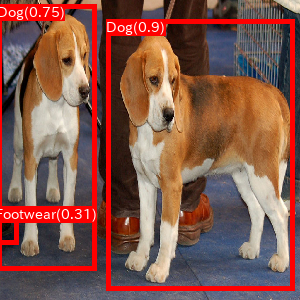

---------------run_tflite:complete
time:0.12sec
0:Person(0.4197121262550354) at [0.7590978  0.15353541 0.9343921  0.2026241 ]
1:Parachute(0.3203359842300415) at [0.07971275 0.44585675 0.17046788 0.49972248]
2:Person(0.31070181727409363) at [0.68369305 0.07340337 0.8309674  0.11650653]
----------------------------------------


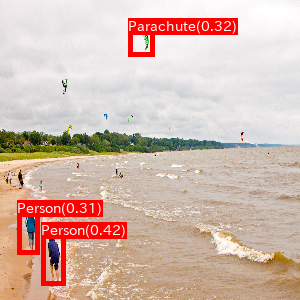

In [9]:
base_model_name="ssd_mobilenet_v2_oid_v4_2018_12_12"
shape=[1,300,300,3]
img_weight=2/255
img_bias=-1
label_map_path=OID_V4_LABEL_MAP_PATH

#convert model to tflite model
create_frozen_pb(base_model_name)
create_tflite_pb(base_model_name,shape)

#run tflite model
classlist=get_labellist_from_labelmap_pb(label_map_path)
model=TFLiteRunner(base_model_name,a=img_weight,b=img_bias,classlist=classlist)
for test_img_path in test_img_path_li:
    model.predict(test_img_path)


---------------create_frozen_pb:complete
tflite_graph.pb  tflite_graph.pbtxt
----------------------------------------
---------------create_tflite_pb:complete
/tf/share/model/object_detection/tflite/ssd_resnet101_v1_fpn_shared_box_predictor_oid_512x512_sync_2019_01_20.tflite
----------------------------------------
---------------run_tflite:complete
time:7.7sec
0:Dog(0.768843412399292) at [0.09586549 0.3860301  0.93363655 0.9827391 ]
1:Dog(0.6520377397537231) at [0.0239675  0.02695154 0.86818004 0.3038612 ]
2:Dog(0.4509248435497284) at [0.03332442 0.3321989  0.8441846  0.7915211 ]
3:Footwear(0.3374115526676178) at [0.6631851  0.31087095 0.8416338  0.47347158]
----------------------------------------


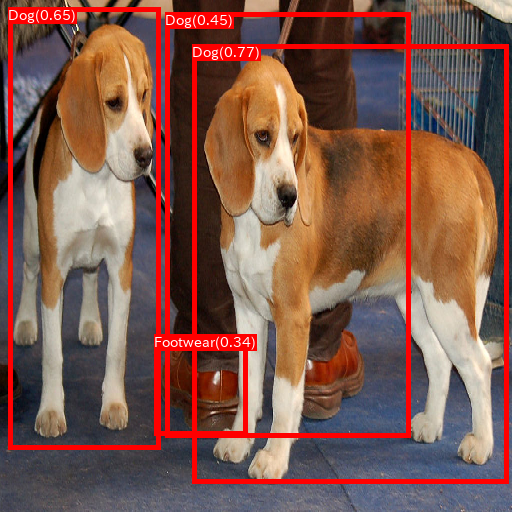

---------------run_tflite:complete
time:4.8sec
0:Person(0.3825433552265167) at [0.76960164 0.15501323 0.94895476 0.20293006]
1:Person(0.3443503975868225) at [0.67117906 0.07948478 0.8453609  0.12394586]
2:Person(0.3062424659729004) at [0.56399447 0.05825694 0.6251454  0.07616881]
----------------------------------------


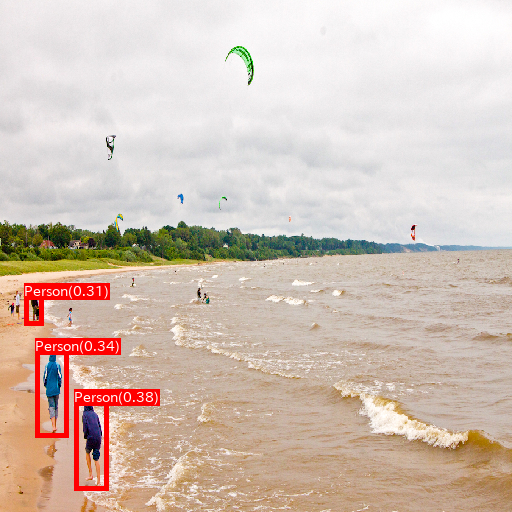

In [10]:
base_model_name="ssd_resnet101_v1_fpn_shared_box_predictor_oid_512x512_sync_2019_01_20"
shape=[1,512,512,3]
img_weight=1
img_bias=0
label_map_path=OID_V4_LABEL_MAP_PATH

#convert model to tflite model
create_frozen_pb(base_model_name)
create_tflite_pb(base_model_name,shape)

#run tflite model
classlist=get_labellist_from_labelmap_pb(label_map_path)
model=TFLiteRunner(base_model_name,a=img_weight,b=img_bias,classlist=classlist)
for test_img_path in test_img_path_li:
    model.predict(test_img_path)


---------------create_frozen_pb:complete
tflite_graph.pb  tflite_graph.pbtxt
----------------------------------------
---------------create_tflite_pb:complete
/tf/share/model/object_detection/tflite/ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tflite
----------------------------------------
---------------run_tflite:complete
time:2.3sec
0:horse(0.7027592658996582) at [0.03101829 0.03682601 0.8530731  0.32665583]
1:horse(0.6137288212776184) at [0.13864377 0.39129847 0.8919698  0.98320967]
2:person(0.39150476455688477) at [-0.00452322  0.5327288   0.25829715  0.7206862 ]
3:horse(0.3759280741214752) at [0.02847323 0.3528465  0.88882816 0.7861912 ]
4:horse(0.32742106914520264) at [-0.00705516  0.30959222  0.8492032   0.63336205]
----------------------------------------


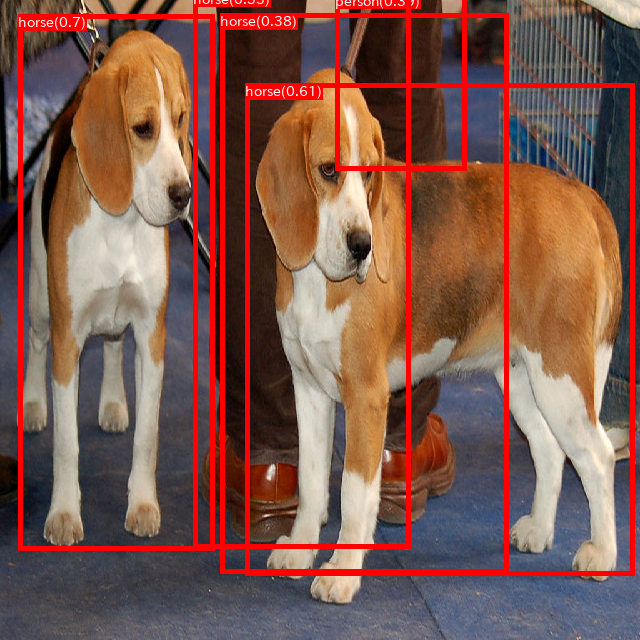

---------------run_tflite:complete
time:1.3sec
0:surfboard(0.7752442359924316) at [0.08884946 0.43896762 0.16856554 0.49624118]
1:person(0.5352407693862915) at [0.684142   0.08260898 0.8481585  0.12350717]
2:person(0.5319532155990601) at [0.5652079  0.0590679  0.62593013 0.07895003]
3:person(0.45761850476264954) at [0.77167594 0.15943609 0.95082986 0.20076014]
4:person(0.3620697855949402) at [0.5670782  0.01948532 0.61913437 0.04088591]
5:surfboard(0.35669904947280884) at [0.26437992 0.20650493 0.31362617 0.22534929]
6:surfboard(0.3384678363800049) at [0.43848416 0.7997008  0.4729652  0.81705326]
----------------------------------------


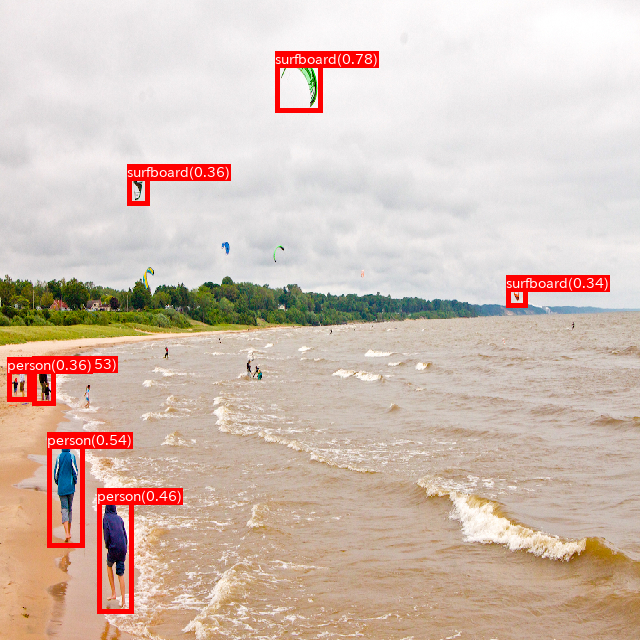

In [11]:
base_model_name="ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03"
shape=[1,640,640,3]
img_weight=2/255
img_bias=-1
label_map_path=COCO_LABEL_MAP_PATH

#convert model to tflite model
create_frozen_pb(base_model_name)
create_tflite_pb(base_model_name,shape)

#run tflite model
classlist=get_labellist_from_labelmap_pb(label_map_path)
model=TFLiteRunner(base_model_name,a=img_weight,b=img_bias,classlist=classlist)
for test_img_path in test_img_path_li:
    model.predict(test_img_path)

---------------create_frozen_pb:complete
tflite_graph.pb  tflite_graph.pbtxt
----------------------------------------
---------------create_tflite_pb:complete
/tf/share/model/object_detection/tflite/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tflite
----------------------------------------
---------------run_tflite:complete
time:4.6sec
0:horse(0.7590570449829102) at [0.12612072 0.37066188 0.9156188  0.97402966]
1:horse(0.7338217496871948) at [0.04971555 0.04087713 0.8565655  0.3148094 ]
2:person(0.4731244444847107) at [0.00154762 0.5301992  0.2514171  0.71562403]
3:car(0.32349056005477905) at [-7.23417848e-04  7.07970023e-01  1.01667106e-01  8.05282950e-01]
4:person(0.3083266019821167) at [0.01009089 0.24611959 0.8130684  0.6843834 ]
----------------------------------------


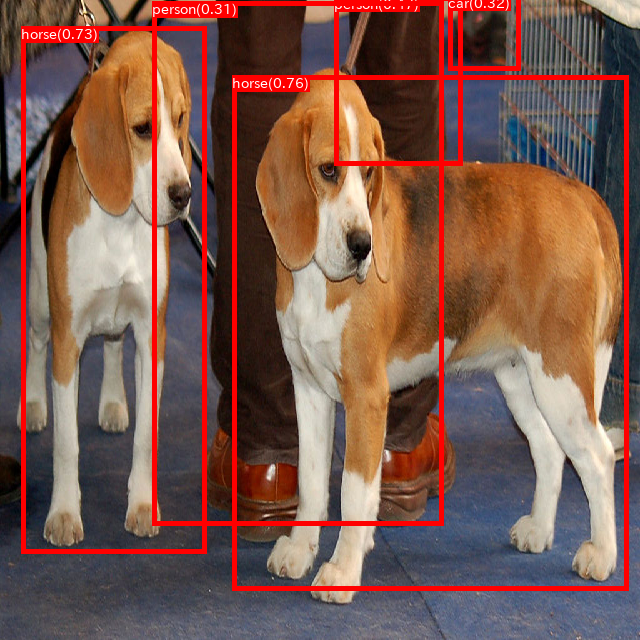

---------------run_tflite:complete
time:1.6sec
0:surfboard(0.5484606027603149) at [0.08763075 0.44023123 0.16911185 0.4966987 ]
1:person(0.5017262697219849) at [0.7786625  0.1591824  0.93648714 0.19947928]
2:person(0.3729709982872009) at [0.6822038  0.08360539 0.8348468  0.12157977]
----------------------------------------


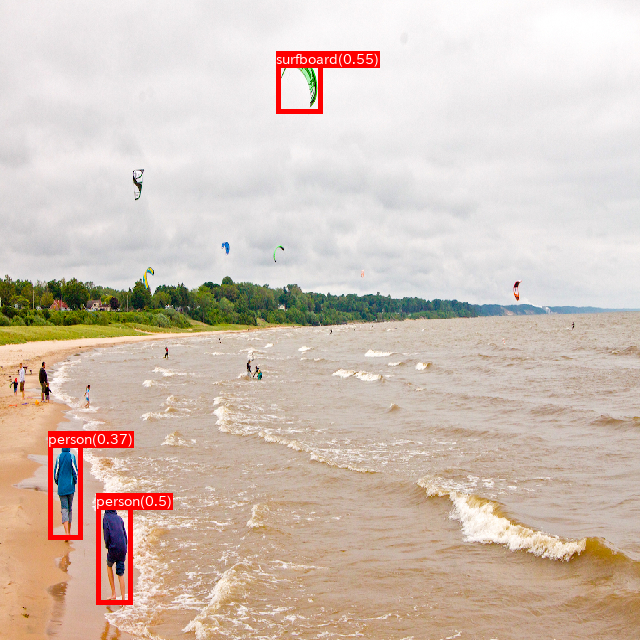

In [12]:
base_model_name="ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03"
shape=[1,640,640,3]
img_weight=1
img_bias=0
label_map_path=COCO_LABEL_MAP_PATH

#convert model to tflite model
create_frozen_pb(base_model_name)
create_tflite_pb(base_model_name,shape)

#run tflite model
classlist=get_labellist_from_labelmap_pb(label_map_path)
model=TFLiteRunner(base_model_name,a=img_weight,b=img_bias,classlist=classlist)
for test_img_path in test_img_path_li:
    model.predict(test_img_path)